In [1]:
import sys

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import cross_entropy

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
import pytorch_lightning as pl
from pytorch_lightning import LightningModule

from transformers import AutoTokenizer
from transformers import GPT2Tokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import GPT2LMHeadModel
from datasets import load_dataset, Dataset, DatasetDict

from tqdm import tnrange

import matplotlib.pyplot as plt

from evaluate import load

import bert_score


## Data

In [2]:
class XSumPreprocessor:
    def __init__(self, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Add special tokens to the tokenizer
        self.special_tokens_dict = {'bos_token': '<bos>', 'eos_token': '<eos>', 'sep_token': '<sep>', 'pad_token': '<pad>'}
        self.num_added_toks = self.tokenizer.add_special_tokens(self.special_tokens_dict)
    def preprocess(self, example):
        # Concatenate article and summary and add special tokens
        encoded_example = tokenizer.encode_plus(
            f'{self.special_tokens_dict["bos_token"]} {example["document"]} {self.special_tokens_dict["sep_token"]} {example["summary"]} {self.special_tokens_dict["eos_token"]}',
            truncation=True,
            padding='max_length',
            max_length=self.max_length
        )

        return encoded_example

    def filter(self, dataset):
        dataset = [sample for sample in dataset if self.tokenizer.sep_token_id in sample['input_ids']]
        return dataset

In [3]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
max_length=1024

preprocessor = XSumPreprocessor(
                tokenizer = tokenizer,
                max_length = max_length
)

# Load XSum dataset
xsum_dataset = load_dataset('xsum')

use_percent = 100
# dataset_train = load_dataset("xsum", split=f"train[:{use_percent}%]")
# dataset_val = load_dataset("xsum", split=f"validation[:{use_percent*2}%]")
# dataset_test = load_dataset("xsum", split=f"test[:{use_percent}%]")
dataset_train = load_dataset("xsum", split=f"train[:{use_percent}]")
dataset_val = load_dataset("xsum", split=f"validation[:{use_percent}]")
dataset_test = load_dataset("xsum", split=f"test[:{use_percent}]")

dataset = DatasetDict({'train': dataset_train, 'validation': dataset_val, 'test': dataset_test})

# Apply the function to all examples in the dataset
xsum_dataset = dataset.map(preprocessor.preprocess, remove_columns=['document', 'summary'])
# Format the dataset to PyTorch tensors and split into training, validation, and test sets
xsum_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

train_dataset = preprocessor.filter(xsum_dataset['train'])
val_dataset = preprocessor.filter(xsum_dataset['validation'])
test_dataset = xsum_dataset['test']


Found cached dataset xsum (/home/studio-lab-user/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset xsum (/home/studio-lab-user/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71)
Found cached dataset xsum (/home/studio-lab-user/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71)
Found cached dataset xsum (/home/studio-lab-user/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71)
Loading cached processed dataset at /home/studio-lab-user/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-f7cfd4753b2ff669.arrow
Loading cached processed dataset at /home/studio-lab-user/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-fed812113622a2f8.arrow
Loading cached processed dataset at /home/studio-lab-user/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf475

## Model

In [4]:
### TODO: Save losses while training ###
### TODO: Add Checkpointing ###


class GPT2FineTuner(LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = GPT2LMHeadModel.from_pretrained("gpt2")
        # Resize token embeddings in case you have added more tokens in the vocab
        self.model.resize_token_embeddings(len(tokenizer))
        self.train_losses = []
        self.validation_losses = []
        
        self.train_losses_epoch=[]
        self.validation_losses_epoch=[]
        
        self.save_hyperparameters()

    def forward(self, input_ids, attention_mask=None):
        return self.model(input_ids, attention_mask=attention_mask)

    def training_step(self, batch, batch_nb):
        input_ids, attention_mask = batch['input_ids'], batch['attention_mask']
        sep_positions = (input_ids == tokenizer.sep_token_id).nonzero(as_tuple=False)
        # Forward pass
        outputs = self(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss only on the reference summary
        loss = 0
        for i, sep_position in enumerate(sep_positions):
            sep_position = sep_position[1]  # Use the single element from the tensor
            shift_logits = logits[i, sep_position:-1,:].contiguous()
            shift_labels = input_ids[i, sep_position+1:].contiguous()
            loss_calculation = cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss += loss_calculation if not torch.isnan(loss_calculation) else 0

        loss = loss / len(sep_positions)  # average loss
        self.train_losses.append(loss)
        self.log('loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return {'loss': loss}

    def validation_step(self, batch, batch_nb):
        input_ids, attention_mask = batch['input_ids'], batch['attention_mask']
        sep_positions = (input_ids == tokenizer.sep_token_id).nonzero(as_tuple=False)
        # Forward pass
        outputs = self(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

       # Calculate loss only on the reference summary
        val_loss = 0
        for i, sep_position in enumerate(sep_positions):
            sep_position = sep_position[1] # Use the single element from the tensor
            shift_logits = logits[i, sep_position:-1, :].contiguous()
            shift_labels = input_ids[i, sep_position+1:].contiguous()
            val_loss += cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        val_loss = val_loss / len(sep_positions)  # average loss
        self.validation_losses.append(val_loss)
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return {'val_loss': val_loss}
    
    def generate(self, input_ids, max_new_tokens=30, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        input_ids=input_ids.clone().detach().reshape((1,-1)).to(device)
        return self.model.generate(input_ids)

    def on_train_epoch_end(self):
        # Calculate average loss for the epoch and append to the list
        avg_train_loss = sum(self.train_losses)/ len(self.train_losses)
        self.train_losses_epoch.append(avg_train_loss.item())

        # Reset epoch loss accumulator
        self.train_losses = []

    def on_validation_epoch_end(self):
        # Calculate average loss for the epoch and append to the list
        avg_val_loss = sum(self.validation_losses) / len(self.validation_losses)
        self.validation_losses_epoch.append(avg_val_loss.item())

        # Reset epoch loss accumulator
        self.validation_losses = []

    def push_to_hub(self, model_name, organization):
        # Save the model
        self.model.push_to_hub(model_name, organization)

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=1e-4)

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, batch_size=2, num_workers=4)
    

In [5]:
model = GPT2FineTuner()

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',  # Choose your metric here
    dirpath='./saved/saved_checkpoints/',
    filename='GPT2FineTuner-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    mode='min',  # or 'max', depending on what you want to monitor
)

trainer = Trainer(max_epochs=3, callbacks=[checkpoint_callback])
trainer.fit(model)

### NB: Will workd once losses are saved ###
#print('training loss', model.train_losses)
#print('validation loss', model.validation_losses)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /home/studio-lab-user/dev/TextpressoMachine/notebooks/saved/saved_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params
------------------------------------------
0 | model | GPT2LMHeadModel | 124 M 
------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
497.772   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (46) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## plotting the results

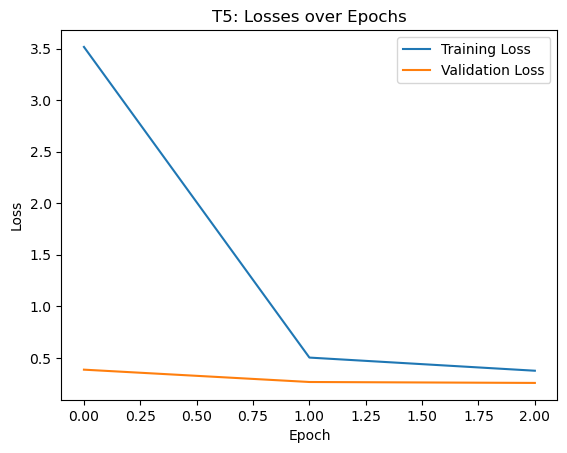

In [6]:
# Plotting the losses
train_losses= model.train_losses_epoch
validation_losses= model.validation_losses_epoch
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses[1:], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('T5: Losses over Epochs')

# Adding legend
plt.legend()

plt.savefig('losses_plot.png')
# Displaying the plot
plt.show()

epoch0: val_loss 0.167
epoch1: val_loss 0.163
epoch2: val_loss 0.165
epoch3: val_loss 0.174
epoch4: val_loss 

In [7]:
# Save the tokenizer
tokenizer.save_pretrained("./saved/tokenizers/")

# The best model is saved at the path:
checkpoint_path = checkpoint_callback.best_model_path
model = GPT2FineTuner.load_from_checkpoint(checkpoint_path)
model.eval()
gpt2_summarizer = model

# Inference

In [8]:
def summarize(model, text, length, device):
    ## From the blog ##
    text = torch.tensor(text, dtype=torch.long, device=device)
    text = text.unsqueeze(0)
    generated = text
    model = model.to(device)
    with torch.no_grad():
        for _ in tnrange(length):
            inputs = {'input_ids': generated}

            outputs = model(**inputs)
            next_token_logits = outputs[0][0, -1, :]
            next_token = torch.multinomial(F.softmax(next_token_logits, dim=-1), num_samples=1)
            generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
    return generated



### Test with one example

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained("./saved/tokenizers/")
example = test_dataset[0]['input_ids']
sep_idx = (example == tokenizer.sep_token_id).nonzero(as_tuple=False).item()
print(sep_idx)

747


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
text = example[:sep_idx].tolist()
summary = example[sep_idx+1:].tolist()
generated_text = summarize(gpt2_summarizer, text, length=100, device=device)

/tmp/ipykernel_3582/1770653979.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(length):


  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
tokenized_summary = generated_text[0, sep_idx:].tolist()
# tokenized_summary = generated_text[0,:].tolist()
id_summary = tokenizer.convert_ids_to_tokens(tokenized_summary,skip_special_tokens=True)
print(len(id_summary))
gpt2_summary = tokenizer.convert_tokens_to_string(id_summary)

0


In [12]:
print('######### Original Text #############')
print(tokenizer.decode(text), end='\n\n')
print('######### GPT2 Summary ##############')
print(gpt2_summary, end='\n\n')
print('######### Ground Truth Summary ###########')
print(tokenizer.decode(summary, skip_special_tokens=True), end='\n\n')

######### Original Text #############
<bos> Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.
Workers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.
The Welsh Government said more people than ever were getting help to address housing problems.
Changes to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.
Prison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.
However, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.
Andrew Stevens, who works in Welsh prisons trying to secure housing for 

# Evaluation

In [13]:


class Evaluator:
    def __init__(self, hypothesis, reference):
        self.hypothesis = hypothesis
        self.reference = reference
        
        self.metrics={
        'rouge1': self.rouge_N(1),
        'rouge2': self.rouge_N(2),
        'rougeL': self.rouge_L(),
        'rougeLsum': self.rouge_L_sum(),
        'bert': self.bert_Score()
    }
        
    def rouge_L(self):
        metric = load("rouge")
        metric_type = 'rougeL'
        rg_score = metric.compute(predictions=self.hypothesis, references=self.reference, rouge_types=[metric_type])[metric_type]
        print('rougeL computed')
        return rg_score
        
    
    def rouge_N(self, n=1):
        metric = load("rouge")
        metric_type = f'rouge{n}'
        rg_score = metric.compute(predictions=self.hypothesis, references=self.reference, rouge_types=[metric_type])[metric_type]
        print('rougeN computed')
        return rg_score
		
		
    def rouge_L_sum(self):
        metric = load("rouge")
        metric_type = 'rougeLsum'
        rg_score = metric.compute(predictions=self.hypothesis, references=self.reference, rouge_types=[metric_type])[metric_type]
        print('rougeLsum computed')
        return rg_score
		
        
    def bert_Score(self):
        metric = load("bertscore")
        all_preds= bert_score.score(self.hypothesis, self.reference, lang='en')
        score = {"precision": (torch.sum(all_preds[0].cpu())/all_preds[0].cpu().numel()).item(), "recall": (torch.sum(all_preds[1].cpu())/all_preds[1].cpu().numel()).item(), "f1":
                (torch.sum(all_preds[2].cpu())/all_preds[2].cpu().numel()).item()}
        print('Bert computed')
        return score
    
    def rouge_L_evaluation(self):
        # Tokenize hypothesos and reference sentences
        hypothesis_tokens = self.hypothesis.split()
        reference_tokens = self.reference.split()

        # Compute the length of the longest common subsequence
        lcs = lcs_length(hypothesis_tokens, reference_tokens)

        # Compute precision, recall, and f1 score
        precision = lcs / len(hypothesis_tokens)
        recall = lcs / len(reference_tokens)
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7))

        return {"precision": precision, "recall": recall, "f1": f1_score}


    def rouge_N_evaluation(self, n=1):
        # split sentences into n-grams
        def ngrams(sentence, n):
            # use a list comprehension to generate n-grams
            return Counter([tuple(sentence[i:i+n]) for i in range(len(sentence) - n + 1)])

        # compute the n-grams for the candidate and reference sentences
        hypothesis_ngrams = ngrams(self.hypothesis.split(" "), n)
        reference_ngrams = ngrams(self.reference.split(" "), n)

        # count the number of shared n-grams
        shared_ngrams = hypothesis_ngrams & reference_ngrams
        shared_count = sum(shared_ngrams.values())

        # calculate precision, recall, and f1 score
        precision = shared_count / sum(hypothesis_ngrams.values())
        recall = shared_count / sum(reference_ngrams.values())
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7))

        return {"precision": precision, "recall": recall, "f1": f1_score}
    
    def rouge_L_sum_evaluation(self):
        # Tokenize candidate and reference summaries
        hypothesis_tokens = self.hypothesis.split()
        reference_tokens = self.reference.split()

        # Compute the length of the longest common subsequence for summarizations
        lcs_sum = lcs_length(hypothesis_tokens, reference_tokens)

        # Compute precision, recall, and f1 score
        precision = lcs_sum / len(hypothesis_tokens)
        recall = lcs_sum / len(reference_tokens)
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7))

        return {"precision": precision, "recall": recall, "f1": f1_score}
    
    @staticmethod
    def lcs_length(s1, s2):
            m, n = len(s1), len(s2)
            dp = [[0] * (n + 1) for _ in range(m + 1)]

            for i in range(1, m + 1):
                for j in range(1, n + 1):
                    if s1[i - 1] == s2[j - 1]:
                        dp[i][j] = dp[i - 1][j - 1] + 1
                    else:
                        dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

            return dp[m][n]
        
        
def evaluate_model(test_data, model, tokenizer, device):
        reference=[]
        candidate=[]
        for input_text_ids, summary in zip(test_data['input_ids'], test_data['summary']):
            
            input_text_ids=torch.tensor(input_text_ids).clone().detach().reshape((1,-1)).to(device)
            generated_summary = model.generate(input_text_ids)  # Generate summary using your model's generate function
            gen_summary=tokenizer.decode(generated_summary[0], skip_special_tokens=True)
            reference.append(summary)
            candidate.append(gen_summary)
        scores = Evaluator(candidate, reference).metrics
        
        return scores
    


In [ ]:
xsum_dataset = dataset.map(preprocessor.preprocess)
# xsum_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
test_dataset = xsum_dataset["train"]
print(test_dataset)
scores=evaluate_model(test_dataset, model, tokenizer, device)
bert_scores=scores['bert']
rouge_1_score=scores['rouge1']
rouge_2_score=scores['rouge2']
rouge_L_score=scores['rougeL']
rouge_L_sum_score=scores['rougeLsum']
print('Bert Scores: Precision ',bert_scores['precision'],'| Recall ',bert_scores['recall'],'| F1Score ',bert_scores['f1'])
print('Rouge-1 Score: ',rouge_1_score)
print('Rouge-2 Score: ',rouge_2_score)
print('Rouge-L Score: ',rouge_L_score)
print('Rouge-L-summ Score: ',rouge_L_sum_score)

Loading cached processed dataset at /home/studio-lab-user/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-18c21e355d9702c0.arrow


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Dataset({
    features: ['document', 'summary', 'id', 'input_ids', 'attention_mask'],
    num_rows: 100
})


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1024, but ``max_length`` is set to 20. This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attenti

rougeN computed
rougeN computed
rougeL computed
rougeLsum computed
